# 1. Install and Import Dependencies

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.2 MB/s eta 0:00:00


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

# 2. Instantiate Model

In [5]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# 3. Encode and Calculate Sentiment

In [13]:
tokens = tokenizer.encode('this is a horrible place, this is my first time and shure it will be my last', return_tensors='pt')

In [14]:
tokens

tensor([[  101, 10372, 10127,   143, 36129, 45795, 10301, 11125,   117, 10372,
         10127, 11153, 10403, 10573, 10110, 31979, 10247, 10197, 11229, 10346,
         11153, 11706,   102]])

In [15]:
#tokenizer.decode(tokens[0])

In [16]:
result = model(tokens)

In [17]:
result.logits

tensor([[ 4.5729,  1.2779, -0.8353, -2.6850, -1.6742]],
       grad_fn=<AddmmBackward0>)

In [18]:
int(torch.argmax(result.logits))+1

1

# 4. Collect Reviews

In [50]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

base_url = 'https://www.yelp.com/biz/social-brew-cafe-pyrmont?start='
num_pages = 7
reviews_list = []

for page in range(1, num_pages + 1):
    url = f'{base_url}{page}'
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        regex = re.compile('.*comment.*')
        results = soup.find_all('p', {'class': regex})

        for result in results:
            review_text = result.get_text(strip=True)
            reviews_list.append(review_text)  # Append individual reviews as dictionaries

    else:
        print(f"Failed to retrieve page {page}. Status code: {response.status_code}")




In [39]:
#r = requests.get('https://www.yelp.com/biz/social-brew-cafe-pyrmont')
#soup = BeautifulSoup(r.text, 'html.parser')
#regex = re.compile('.*comment.*')
#results = soup.find_all('p', {'class':regex})
#reviews = [result.text for result in results]

In [51]:
len(reviews_list)

77

# 5. Load Reviews into DataFrame and Score

In [52]:
import numpy as np
import pandas as pd

In [53]:
df = pd.DataFrame(np.array(reviews_list), columns=['review'])

In [54]:
df.head()

,review
0,Six of us met here for breakfast before our wa...
1,Great place with delicious food and friendly s...
2,Some of the best Milkshakes me and my daughter...
3,Great food amazing coffee and tea. Short walk ...
4,It was ok. Had coffee with my friends. I'm new...


In [55]:
df.shape

(77, 1)

In [56]:
df['review'].iloc[0]

"Six of us met here for breakfast before our walk to Manly. We were enjoying visiting with each other so much that I apologize for not taking any photos.We all enjoyed our food, as well as our coffee and tea drinks.We were greeted immediately by a friendly server asking if we would like to sit inside or out. We said we would like inside, but weren't exactly sure how many were joining us yet- at least 4. We were told this was no problem, the more the merrier. A few minutes later when 4 more joined our party and we explained to the server we had 6, he just quickly switched our table.I really enjoyed my serenity tea, just what I needed after a long flight in from Sfo that morning. Everyone else were more interested in the lattes for expresso drinks. All said they were hot and delicious.2 of us ordered the avo on toast. So yummy with the beetroot... I will start adding this to mine now at home, and have fond memories for my trip to Sydney.2 friends ordered the salmon Benedict- saying it wa

In [57]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [59]:
sentiment_score(df['review'].iloc[10])

4

In [60]:
df['sentiment'] = df['review'].apply(lambda x: sentiment_score(x[:512]))

512 to grab everything before 512 token value in each review, this nlp pipeline is limited to how much tokens you can pass to the model at one time

In [61]:
df

,review,sentiment
0,Six of us met here for breakfast before our wa...,4
1,Great place with delicious food and friendly s...,5
2,Some of the best Milkshakes me and my daughter...,5
3,Great food amazing coffee and tea. Short walk ...,5
4,It was ok. Had coffee with my friends. I'm new...,3
...,...,...
72,This place is a gem. The ambiance is to die fo...,2
73,I went here a little while ago- a beautiful mo...,2
74,Ron & Jo are on the go down under and Wow! We...,5
75,5 stars all around for the staff and delicious...,5


In [62]:
print(df['review'].iloc[3])
print(df['sentiment'].iloc[3])

Great food amazing coffee and tea. Short walk from the harbor. Staff was very friendly
5


In [63]:
def specific_rev(line):
  print(df['review'].iloc[line])
  print(df['sentiment'].iloc[line])

specific_rev(7)

Great staff and food.  Must try is the pan fried Gnocchi!  The staff were really friendly and the coffee was good as well
5


In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

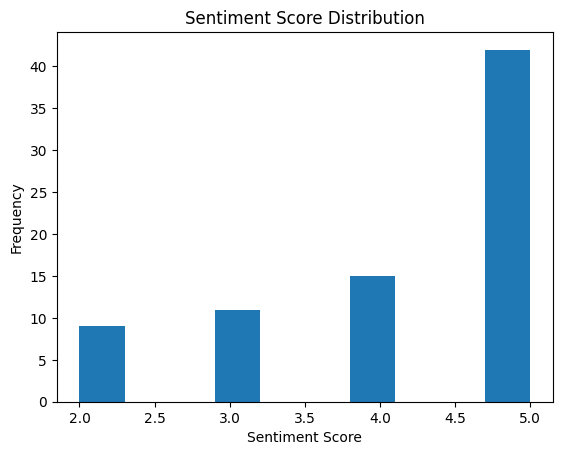

In [71]:
plt.hist(df['sentiment'])
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution')
plt.show()

In [72]:
sentiment_score("a great coffee honestly, but it could be better")

4

Plot the most frequent words

In [74]:
!pip install wordcloud

In [75]:

from wordcloud import WordCloud

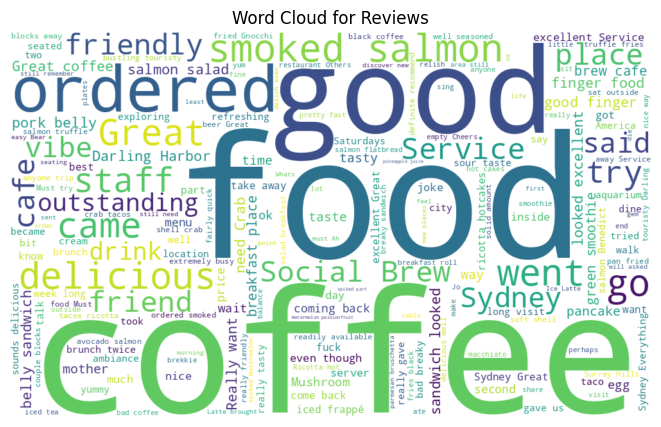

In [78]:
text_data = ' '.join(df['review'])

# Generate the word cloud
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Reviews")
plt.show()